# Earth Engine for gathering data

Google Earth Engine is a powerful tool for geospatial data analysis. Here, we will discuss how to use its Python API for gathering data from Landsat, Sentinel, and NAIP imagery.

To start off with, request access to Google Earth Engine at: [](https://earthengine.google.com/). This may take some time. Once approved, install the Python API and get credentials for using the API following [these instructions](https://developers.google.com/earth-engine/guides/python_install-conda#mac_6). Be sure to try out the test code they suggest to make sure Earth Engine is running successfully):

In [2]:
import ee

# Initialize the Earth Engine module.
ee.Initialize()

# Print metadata for a DEM dataset.
print(ee.Image('USGS/SRTMGL1_003').getInfo())

{'type': 'Image', 'bands': [{'id': 'elevation', 'data_type': {'type': 'PixelType', 'precision': 'int', 'min': -32768, 'max': 32767}, 'dimensions': [1296001, 417601], 'crs': 'EPSG:4326', 'crs_transform': [0.0002777777777777778, 0, -180.0001388888889, 0, -0.0002777777777777778, 60.00013888888889]}], 'id': 'USGS/SRTMGL1_003', 'version': 1624974026135861, 'properties': {'system:visualization_0_min': '0.0', 'type_name': 'Image', 'thumb': 'https://mw1.google.com/ges/dd/images/SRTM90_V4_thumb.png', 'description': '<p>The Shuttle Radar Topography Mission (SRTM, see <a href="https://onlinelibrary.wiley.com/doi/10.1029/2005RG000183/full">Farr\net al. 2007</a>)\ndigital elevation data is an international research effort that\nobtained digital elevation models on a near-global scale. This\nSRTM V3 product (SRTM Plus) is provided by NASA JPL\nat a resolution of 1 arc-second (approximately 30m).</p><p>This dataset has undergone a void-filling process using open-source data\n(ASTER GDEM2, GMTED2010, 

If the above code yields output, you'll know you're ready for to go!

## Selecting imagery



In [109]:
from osm_tools import _bbox_from_point, gdf_from_bbox
def osm2gee_bbox(bbox):
    """
    convert bbox from lat lon (OSM default) to lon lat (GEE default)
    """
    return bbox[1], bbox[0], bbox[3], bbox[2]
lat, log = 29.475722, -95.636167 # Coal 1, 1000
#lat, log = 33.0606,	-83.8075 # Coal 2, 1000
# lat, log = 27.6058,	-82.3456 # Oil 3, 750
# lat, log = 43.4586,	-76.5319 # Oil 4, 750
# lat, log = 26.6986,	-80.3747 # Gas 5, 1250
distance = 500
bbox = _bbox_from_point((lat, log), distance)
bbox = osm2gee_bbox(bbox)

In [128]:
from geetools import batch

def download_NAIP_toLocal(bbox, name, scale=1):
    """
    downloads NAIP imagery from the specified bounding box and saves it as `name`
    """
    AOI = ee.Geometry.Rectangle(list(bbox), "EPSG:4326", False)

    collection = (
        ee.ImageCollection("USDA/NAIP/DOQQ")
        .filterDate("2010-01-01", "2021-09-19")
        .filterBounds(AOI)
        .select(['R', 'G', 'B'])
    )

    image = ee.Image(collection.mosaic()).clip(AOI)
    batch.image.toLocal(image, name, scale=scale, region=AOI)

name = 'naipsample'
download_NAIP_toLocal(bbox, name, scale=1)

In [110]:
def download_Landsat8_toLocal(bbox, name, scale=1):
    """
    downloads Landsat 8 imagery from the specified bounding box and saves it as `name`
    """
    AOI = ee.Geometry.Rectangle(list(bbox), "EPSG:4326", False)

    collection = (
        ee.ImageCollection("LANDSAT/LC08/C01/T1")
        .filterDate("2010-01-01", "2021-09-19")
        .filterBounds(AOI)
        .select(['B4', 'B3', 'B2'])
    )

    image = ee.Image(collection.mosaic()).clip(AOI)
    batch.image.toLocal(image, name, scale=scale, region=AOI)

name = 'Landsat8sample'
download_Landsat8_toLocal(bbox, name, scale=1)

In [124]:
def download_sentinel2_toLocal(bbox, name, scale=1):
    """
    downloads Sentinel 2 imagery from the specified bounding box and saves it as `name`
    """
    AOI = ee.Geometry.Rectangle(list(bbox), "EPSG:4326", False)

    collection = (
        ee.ImageCollection("COPERNICUS/S2")
        .filterDate("2010-01-01", "2021-09-19")
        .filterBounds(AOI)
        .select(['B4', 'B3', 'B2']) 
    )
    image = ee.Image(collection.mosaic()).clip(AOI)
    batch.image.toLocal(image, name, scale=scale, region=AOI)
name = 'S2sample'
download_sentinel2_toLocal(bbox, name, scale=1)
# Unzip the files
import zipfile
path_to_zip_file = 'S2sample.zip'
directory_to_extract_to = 'S2sample'
with zipfile.ZipFile(path_to_zip_file, 'r') as zip_ref:
    zip_ref.extractall(directory_to_extract_to)

In [129]:
# Unzip the files
import zipfile
path_to_zip_file = 'naipsample.zip'
directory_to_extract_to = 'naipsample'
with zipfile.ZipFile(path_to_zip_file, 'r') as zip_ref:
    zip_ref.extractall(directory_to_extract_to)

In [145]:
# Combine the files:
import rasterio

def stack_bands(name, outname):
    # file_list = [name + '.R.tif', name + '.G.tif', name + '.B.tif']
    file_list = [name + '.B4.tif', name + '.B3.tif', name + '.B2.tif']
    # Read metadata of first file
    with rasterio.open(file_list[0]) as src0:
        meta = src0.meta

    # Update meta to reflect the number of layers
    meta.update(count = len(file_list))

    # Read each layer and write it to stack
    with rasterio.open(outname, 'w', **meta) as dst:
        for id, layer in enumerate(file_list, start=1):
            with rasterio.open(layer) as src1:
                dst.write_band(id, src1.read(1))

outname = "stacked.tif"
stack_bands('S2sample/download',outname)

In [144]:
# save images
from PIL import Image
im = Image.open(outname)
im.save(outname + '.jpg', 'JPEG')

UnidentifiedImageError: cannot identify image file 'stacked.tif'

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


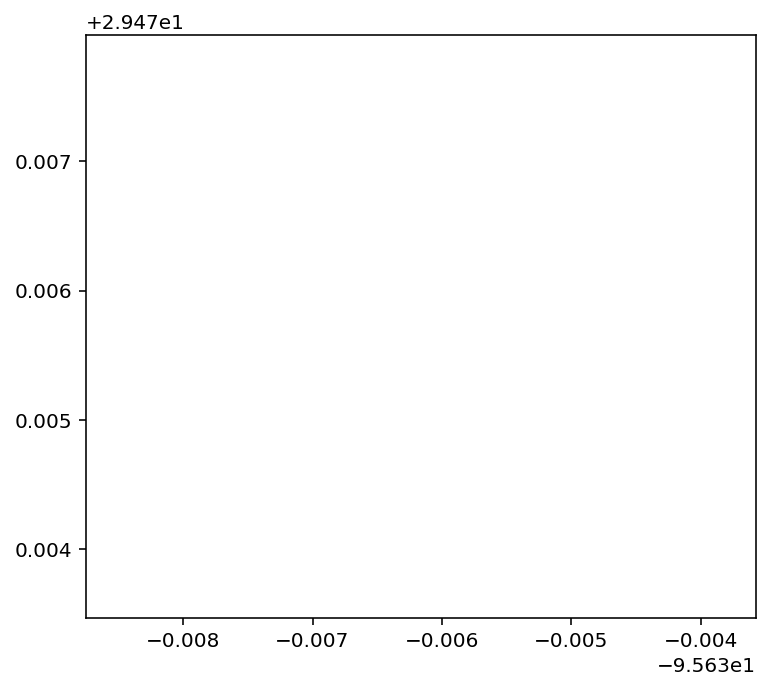

In [146]:
# Plot the example
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
import matplotlib.pyplot as plt
from rasterio.plot import show

fig, ax = plt.subplots(num='main', figsize=(6,6))

from rasterio.plot import show
data = rasterio.open(outname)
show(data.read([1,2,3]).astype('float')/255, transform=data.transform, ax=ax)
# show(data.read([1,2,3]), transform=data.transform, ax=ax)

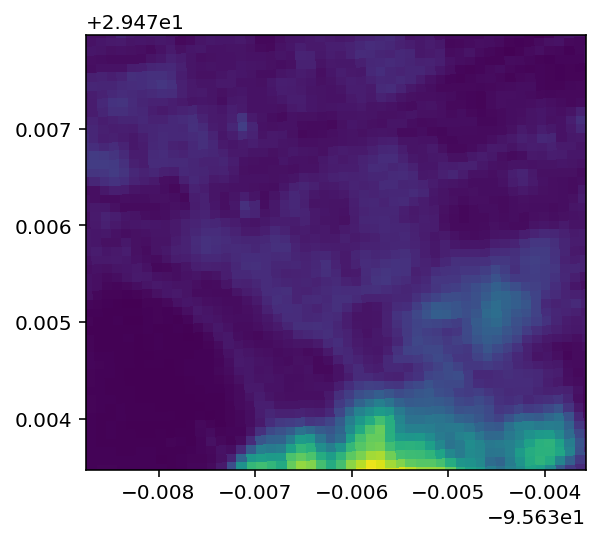

In [148]:
show(data)